Great — go ahead and upload the datasets now, and I’ll help you directly apply the KMeans clustering pipeline to them.
Please upload:

The small dataset (~4,000 rows)
The large dataset (~290,000 rows)
Once they're uploaded, I will:
Load and inspect the data structure.
Apply the 70/20/10 split.
Scale the features.
Perform PCA + t-SNE (2D & 3D).
Tune KMeans using elbow and silhouette.
Run final KMeans.
Analyze and label clusters.
Provide evaluation and explainability tools.
Please upload the files now.

In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

import joblib


**Loading the Imputed Datasets**

In [12]:
# drop index columns
UK_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded_data.csv")
US_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_encoded_data.csv")
# Drop latitude and longitude columns
UK_data.drop(columns=['Report ID', 'Report Version'], inplace=True)
US_data.drop(columns=['Report ID', 'Report Version'], inplace=True)




**Sample Large UK data**

In [13]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Suppose the column you want to stratify on is named 'target_column'
target_col = 'Highest Injury Severity Alleged'  # replace this with your actual column name

# Stratified sampling: 20% sample size
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, sample_index in split.split(UK_data, UK_data[target_col]):
    UK_data = UK_data.iloc[sample_index]

print(UK_data[target_col].value_counts(normalize=True))  # check proportions


Highest Injury Severity Alleged
1.0    0.774507
2.0    0.210088
0.0    0.015406
Name: proportion, dtype: float64


**K-Means++ Hyperparameter Testing using GridSearch**
- Best parameters for US Data: n_clusters=2, init=k-means++, max_iter=100, tol=0.0001 Best silhouette score: 0.6360

**Plotting Elbow Method**

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import matplotlib.pyplot as plt

def perform_kmeans_random_search(data, dataset_name, n_iter=30, random_state=42):
    print(f"\nPerforming K-Means randomized search for {dataset_name}...")

    param_distributions = {
        'n_clusters': range(2, 21),  # Try more cluster sizes
        'init': ['k-means++', 'random'],  # Add 'random'
        'max_iter': [300, 500, 1000],  # Try longer iterations
        'tol': [1e-4, 1e-3],  # Keep reasonable tolerance
        'n_init': [10, 20]  # Try more initializations
    }

    sampler = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=random_state))

    best_score = -1
    best_params = None
    scores = []

    for params in sampler:
        try:
            kmeans = KMeans(
                n_clusters=params['n_clusters'],
                init=params['init'],
                max_iter=params['max_iter'],
                tol=params['tol'],
                n_init=params['n_init'],
                random_state=random_state
            )
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            scores.append((score, params))

            print(f"k={params['n_clusters']}, init={params['init']}, max_iter={params['max_iter']}, "
                  f"tol={params['tol']}, n_init={params['n_init']} => silhouette={score:.4f}")

            if score > best_score:
                best_score = score
                best_params = params

        except Exception as e:
            print(f"Failed for params {params}: {e}")

    print(f"\n🔍 Best parameters for {dataset_name}:")
    print(f"{best_params}")
    print(f"🏆 Best silhouette score: {best_score:.4f}")

    # Plot silhouette scores by n_clusters (filter by best init/tol/max_iter/n_init)
    filtered_scores = [
        s for s in scores if all([
            s[1]['init'] == best_params['init'],
            s[1]['tol'] == best_params['tol'],
            s[1]['max_iter'] == best_params['max_iter'],
            s[1]['n_init'] == best_params['n_init']
        ])
    ]
    ks = [s[1]['n_clusters'] for s in filtered_scores]
    sil_scores = [s[0] for s in filtered_scores]

    return best_params


# Example usage:
us_best_params = perform_kmeans_random_search(US_data, "US Data", n_iter=5)
uk_best_params = perform_kmeans_random_search(UK_data, "UK Data", n_iter=5)


Performing K-Means randomized search for US Data...
k=19, init=random, max_iter=500, tol=0.001, n_init=10 => silhouette=0.5050
k=11, init=k-means++, max_iter=300, tol=0.001, n_init=20 => silhouette=0.5409
k=11, init=random, max_iter=500, tol=0.0001, n_init=10 => silhouette=0.5420
k=18, init=k-means++, max_iter=1000, tol=0.0001, n_init=20 => silhouette=0.5148
k=2, init=k-means++, max_iter=1000, tol=0.001, n_init=20 => silhouette=0.6179

🔍 Best parameters for US Data:
{'tol': 0.001, 'n_init': 20, 'n_clusters': 2, 'max_iter': 1000, 'init': 'k-means++'}
🏆 Best silhouette score: 0.6179

Performing K-Means randomized search for UK Data...
k=19, init=random, max_iter=500, tol=0.001, n_init=10 => silhouette=0.3593
k=11, init=k-means++, max_iter=300, tol=0.001, n_init=20 => silhouette=0.4483
k=11, init=random, max_iter=500, tol=0.0001, n_init=10 => silhouette=0.4469
k=18, init=k-means++, max_iter=1000, tol=0.0001, n_init=20 => silhouette=0.3792
k=2, init=k-means++, max_iter=1000, tol=0.001, n_

US


KMeans Clustering Progress: 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]


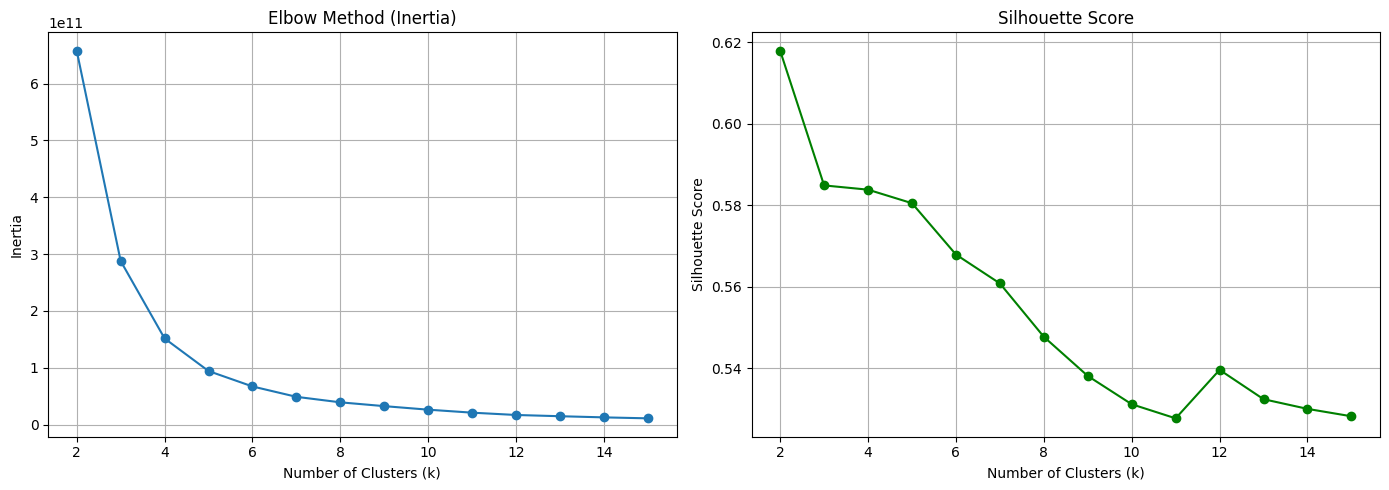

UK


KMeans Clustering Progress: 100%|██████████| 14/14 [02:48<00:00, 12.01s/it]


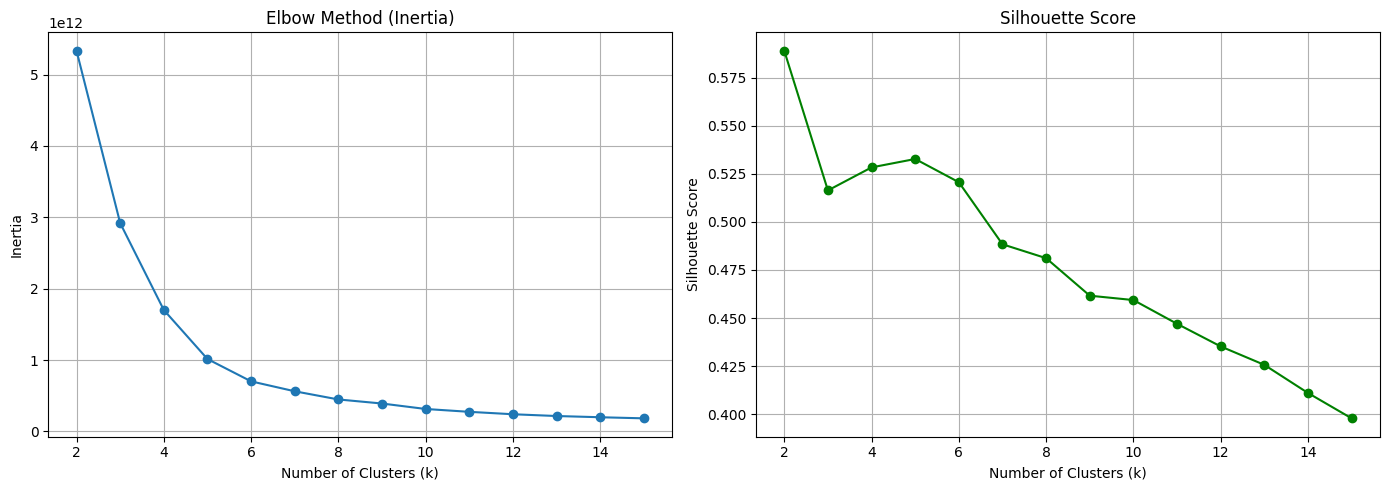

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_kmeans_elbow_silhouette(data, max_k=10):
    inertias = []
    silhouettes = []
    Ks = range(2, max_k + 1)

    for k in tqdm(Ks, desc="KMeans Clustering Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)  # n_init=1 for speed; you can use 'auto' for better stability
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score for the entire dataset
        score = silhouette_score(data, labels, random_state=42)
        silhouettes.append(score)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(Ks, inertias, marker='o')
    ax[0].set_title('Elbow Method (Inertia)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Inertia')
    ax[0].grid(True)

    ax[1].plot(Ks, silhouettes, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

print("US")
plot_kmeans_elbow_silhouette(US_data, max_k=15)

print("UK")
plot_kmeans_elbow_silhouette(UK_data, max_k=15)



In [19]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit to data and transform it
UK_data = scaler.fit_transform(UK_data)




In [20]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: CLUSTERING AND SAMPLING (Your existing code)
# ============================================================================

# 1. Cluster full UK dataset first
UK_data['cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(UK_data)

# 2. Stratified sample
def stratified_sample(df, stratify_col, n_samples, random_state=42):
    proportions = df[stratify_col].value_counts(normalize=True)
    samples_per_group = (proportions * n_samples).round().astype(int)
    sampled_df = (
        df.groupby(stratify_col, group_keys=False)
          .apply(lambda x: x.sample(min(samples_per_group[x.name], len(x)), random_state=random_state))
          .reset_index(drop=True)
    )
    return sampled_df

UK_sampled_stratified = stratified_sample(UK_data, stratify_col='cluster', n_samples=30000)

# 3. Run t-SNE on the stratified sample (2D)
print("Running 2D t-SNE on UK data...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=250, verbose=1)
tsne_results_2d = tsne_2d.fit_transform(UK_sampled_stratified.drop(columns=['cluster']))
UK_sampled_stratified['tsne_1'] = tsne_results_2d[:, 0]
UK_sampled_stratified['tsne_2'] = tsne_results_2d[:, 1]

# 4. Run t-SNE on the stratified sample (3D)
print("Running 3D t-SNE on UK data...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=15, max_iter=250, verbose=1)
tsne_results_3d = tsne_3d.fit_transform(UK_sampled_stratified.drop(columns=['cluster', 'tsne_1', 'tsne_2']))
UK_sampled_stratified['tsne_3d_1'] = tsne_results_3d[:, 0]
UK_sampled_stratified['tsne_3d_2'] = tsne_results_3d[:, 1]
UK_sampled_stratified['tsne_3d_3'] = tsne_results_3d[:, 2]

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_tsne_2d(df, title='t-SNE of Data'):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='Set1', alpha=0.7, s=50)
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_tsne_3d(df, title='3D t-SNE of Data'):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique clusters and colors
    unique_clusters = sorted(df['cluster'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
    
    # Plot each cluster with different colors
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(cluster_data['tsne_3d_1'], 
                  cluster_data['tsne_3d_2'], 
                  cluster_data['tsne_3d_3'],
                  c=[colors[i]], 
                  label=f'Cluster {cluster}',
                  alpha=0.7,
                  s=30)
    
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.set_title(title, fontsize=16)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# PCA ANALYSIS FOR INTERPRETABILITY
# ============================================================================

def analyze_with_pca_uk(df_scaled, clusters, n_components=5):
    """Use PCA for more interpretable components"""
    
    # Remove cluster column if it exists
    feature_data = df_scaled.drop(columns=['cluster'], errors='ignore')
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(feature_data)
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['cluster'] = clusters
    
    print("=== UK PCA ANALYSIS ===")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
    
    # Show feature contributions to each component
    feature_names = feature_data.columns
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=feature_names
    )
    
    print("\n=== TOP FEATURE CONTRIBUTIONS TO EACH COMPONENT ===")
    for i in range(min(3, n_components)):  # Show first 3 components
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (explains {pca.explained_variance_ratio_[i]:.1%} of variance):")
        
        # Get top positive and negative contributors
        contributions = components_df[pc_name].abs().sort_values(ascending=False)
        top_features = contributions.head(10)
        
        for feature in top_features.index:
            coeff = components_df.loc[feature, pc_name]
            print(f"  {feature}: {coeff:.3f}")
    
    return pca_df, pca, components_df

# ============================================================================
# STATISTICAL CLUSTER PROFILING
# ============================================================================

def statistical_cluster_analysis_uk(df, cluster_col='cluster'):
    """Comprehensive statistical analysis of UK clusters"""
    
    print("\n=== UK STATISTICAL CLUSTER ANALYSIS ===")
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove cluster and tsne columns from analysis
    cols_to_remove = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    for col in cols_to_remove:
        if col in numerical_cols:
            numerical_cols.remove(col)
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    cluster_profiles = {}
    
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        cluster_profiles[cluster_id] = {}
        
        print(f"\n=== CLUSTER {cluster_id} ({len(cluster_data)} samples, {len(cluster_data)/len(df)*100:.1f}%) ===")
        
        # Numerical features analysis
        if numerical_cols:
            print("\nKey Numerical Features (mean ± std):")
            feature_differences = []
            
            for col in numerical_cols:
                if col in cluster_data.columns:
                    cluster_mean = cluster_data[col].mean()
                    cluster_std = cluster_data[col].std()
                    overall_mean = df[col].mean()
                    overall_std = df[col].std()
                    
                    # Calculate how different this cluster is from overall mean
                    if overall_std > 0:
                        diff_from_overall = (cluster_mean - overall_mean) / overall_std
                        feature_differences.append((col, abs(diff_from_overall), diff_from_overall))
                        
                        cluster_profiles[cluster_id][col] = {
                            'mean': cluster_mean,
                            'std': cluster_std,
                            'diff_from_overall': diff_from_overall
                        }
            
            # Show top 10 most different features
            feature_differences.sort(key=lambda x: x[1], reverse=True)
            for col, abs_diff, diff in feature_differences[:10]:
                cluster_mean = cluster_profiles[cluster_id][col]['mean']
                cluster_std = cluster_profiles[cluster_id][col]['std']
                status = "HIGH" if diff > 0.5 else "LOW" if diff < -0.5 else "NORMAL"
                print(f"  {col}: {cluster_mean:.3f} ± {cluster_std:.3f} ({status}, {diff:+.2f}σ)")
        
        # Categorical features analysis
        if categorical_cols:
            print("\nTop Categorical Features:")
            for col in categorical_cols[:5]:  # Show top 5
                if col in cluster_data.columns and not cluster_data[col].isna().all():
                    top_values = cluster_data[col].value_counts().head(3)
                    cluster_profiles[cluster_id][col] = top_values.to_dict()
                    
                    print(f"  {col}:")
                    for value, count in top_values.items():
                        percentage = (count / len(cluster_data)) * 100
                        print(f"    {value}: {percentage:.1f}%")
    
    return cluster_profiles

# ============================================================================
# FEATURE IMPORTANCE FOR CLUSTER PREDICTION
# ============================================================================

def cluster_feature_importance_uk(df, cluster_col='cluster'):
    """Use Random Forest to find which features best predict UK clusters"""
    
    print("\n=== UK FEATURE IMPORTANCE FOR CLUSTER PREDICTION ===")
    
    # Prepare data
    cols_to_exclude = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    feature_data = df.drop(columns=cols_to_exclude, errors='ignore')
    
    # Handle categorical variables (simple encoding)
    feature_data_encoded = pd.get_dummies(feature_data, drop_first=True)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf.fit(feature_data_encoded, df[cluster_col])
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_data_encoded.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nModel Accuracy: {rf.score(feature_data_encoded, df[cluster_col]):.3f}")
    print("\nTop 20 Most Important Features for UK Cluster Prediction:")
    for idx, row in importance_df.head(20).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return importance_df, rf

# ============================================================================
# VISUALIZATION HELPERS
# ============================================================================

def plot_cluster_comparison_uk(df, cluster_col='cluster', max_features=12):
    """Create comparison plots for UK clusters"""
    
    # Get numerical features (excluding t-SNE and cluster columns)
    cols_to_exclude = [cluster_col, 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']
    numerical_features = df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_features if col not in cols_to_exclude][:max_features]
    
    n_features = len(numerical_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, feature in enumerate(numerical_features):
        if i < len(axes):
            sns.boxplot(data=df, x=cluster_col, y=feature, ax=axes[i], palette='Set1')
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].tick_params(axis='x', rotation=0)
    
    # Hide unused subplots
    for i in range(len(numerical_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_cluster_heatmap_uk(cluster_profiles):
    """Create a heatmap showing UK cluster characteristics"""
    
    # Extract numerical features for heatmap
    numerical_data = {}
    features = []
    
    for cluster_id, profile in cluster_profiles.items():
        numerical_data[f'Cluster_{cluster_id}'] = {}
        for feature, stats in profile.items():
            if isinstance(stats, dict) and 'diff_from_overall' in stats:
                numerical_data[f'Cluster_{cluster_id}'][feature] = stats['diff_from_overall']
                if feature not in features:
                    features.append(feature)
    
    if numerical_data and features:
        heatmap_df = pd.DataFrame(numerical_data).T
        
        # Select top features by variance across clusters
        feature_variance = heatmap_df.var().sort_values(ascending=False)
        top_features = feature_variance.head(20).index.tolist()
        heatmap_df = heatmap_df[top_features]
        
        plt.figure(figsize=(15, 8))
        sns.heatmap(heatmap_df, annot=True, cmap='RdBu_r', center=0, 
                   fmt='.2f', cbar_kws={'label': 'Standard Deviations from Overall Mean'})
        plt.title('UK Cluster Characteristics Heatmap\n(Top 20 Most Discriminating Features)', fontsize=14)
        plt.tight_layout()
        plt.show()

# ============================================================================
# COMPREHENSIVE ANALYSIS FUNCTION
# ============================================================================

def comprehensive_uk_cluster_analysis(df_scaled, df_sampled, categorical_cols):
    """Run all analysis methods for UK data"""
    
    print("UK COMPREHENSIVE CLUSTER ANALYSIS (5 Clusters)")
    print("=" * 60)
    
    # Display cluster distribution
    print("\nCluster Distribution:")
    cluster_counts = df_sampled['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df_sampled)) * 100
        print(f"Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")
    
    # Method 1: PCA Analysis
    pca_df, pca_model, components_df = analyze_with_pca_uk(df_scaled, df_scaled['cluster'])
    
    # Method 2: Statistical Analysis
    cluster_profiles = statistical_cluster_analysis_uk(df_sampled)
    
    # Method 3: Feature Importance
    importance_df, rf_model = cluster_feature_importance_uk(df_sampled)
    
    # Method 4: Visualizations
    print("\nCreating visualizations...")
    
    # 2D t-SNE plot
    plot_tsne_2d(df_sampled, title='UK Data 2D t-SNE (Stratified Sample, 5 Clusters)')
    
    # 3D t-SNE plot
    plot_tsne_3d(df_sampled, title='UK Data 3D t-SNE (Stratified Sample, 5 Clusters)')
    
    # Feature comparison plots
    plot_cluster_comparison_uk(df_sampled)
    
    # Cluster characteristics heatmap
    create_cluster_heatmap_uk(cluster_profiles)
    
    return {
        'pca_results': pca_df,
        'pca_model': pca_model,
        'components': components_df,
        'cluster_profiles': cluster_profiles,
        'feature_importance': importance_df,
        'rf_model': rf_model,
        'cluster_distribution': cluster_counts
    }

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

# Define UK categorical columns (adjust as needed for your UK dataset)
uk_categorical_cols = ['Make', 'Model', 'Model Year', 'ADS Equipped?', 
                      'Automation System Engaged?', 'Incident Time (24:00)', 'City', 'State',
                      'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting',
                      'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement',
                      'Weather', 'SV Contact Area', 'Country']

# Run comprehensive analysis
print("Starting comprehensive UK cluster analysis...")
uk_results = comprehensive_uk_cluster_analysis(UK_data, UK_sampled_stratified, uk_categorical_cols)

# ============================================================================
# SUMMARY INSIGHTS
# ============================================================================

print("\n" + "="*60)
print("SUMMARY INSIGHTS")
print("="*60)

print(f"\n1. CLUSTER SIZES:")
for cluster_id, count in uk_results['cluster_distribution'].items():
    percentage = (count / len(UK_sampled_stratified)) * 100
    print(f"   Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")

print(f"\n2. TOP 5 MOST IMPORTANT FEATURES FOR CLUSTERING:")
for idx, row in uk_results['feature_importance'].head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

print(f"\n3. PCA EXPLANATION:")
pca_var = uk_results['pca_model'].explained_variance_ratio_
print(f"   First 3 components explain {np.sum(pca_var[:3]):.1%} of variance")
print(f"   PC1: {pca_var[0]:.1%}, PC2: {pca_var[1]:.1%}, PC3: {pca_var[2]:.1%}")

print(f"\n4. MODEL PERFORMANCE:")
print(f"   Random Forest can predict clusters with {uk_results['rf_model'].score(pd.get_dummies(UK_sampled_stratified.drop(columns=['cluster', 'tsne_1', 'tsne_2', 'tsne_3d_1', 'tsne_3d_2', 'tsne_3d_3']), drop_first=True), UK_sampled_stratified['cluster']):.1%} accuracy")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices